In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import stattools as stt
from statsmodels import tsa
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings

warnings.filterwarnings("ignore")

def is_stationary(df, maxlag=52, autolag=None, regression='ct'):
    adf_test = stt.adfuller(df.values,maxlag=maxlag, autolag=autolag, regression=regression)
#     print(adf_test)
    adf = adf_test[0]
    cv_5 = adf_test[4]["5%"]
    result = adf < cv_5
#     print(adf, '--', cv_5, result)
    return result


def d_param(df, max_lag=52):
    d = 0
    if ~is_stationary(df):
        for i in range(1, max_lag):
            if is_stationary(df.diff(i).dropna()):
                d = i
                break;
    return d

def ARMA_params(df):
#     p, q = tsa.stattools.arma_order_select_ic(np.asarray(df.dropna()),ic='aic').aic_min_order
    p, q = tsa.stattools.arma_order_select_ic(np.asarray(df.dropna()), max_ar=4, max_ma=2, ic='aic', trend='c').aic_min_order
    
    return p, q



filePath = "Datasets/daily-min-temperatures.csv"
# filePath = "Datasets/daily-total-female-births.csv"
# filePath = "Datasets/monthly-sunspots.csv"
# filePath = "Datasets/shampoo.csv"
# filePath = "Datasets/DS_AR1_5766.csv"
# filePath = "Datasets/DS_MA1_wthw5.csv"
# filePath = "Datasets/DS_AR1_5766.csv"
# filePath = "Datasets/DS_AR2_asg3ft1.csv"
# filePath = "Datasets/DS_MA2_aafe.csv"
# filePath = "Datasets/DS_MA2_asdw.csv"
# filePath = "Datasets/DS_AR2_56q65aa.csv"

csvFile = pd.read_csv(filePath)
print(csvFile)

            Date  Temp
0     1981-01-01  20.7
1     1981-01-02  17.9
2     1981-01-03  18.8
3     1981-01-04  14.6
4     1981-01-05  15.8
...          ...   ...
3645  1990-12-27  14.0
3646  1990-12-28  13.6
3647  1990-12-29  13.5
3648  1990-12-30  15.7
3649  1990-12-31  13.0

[3650 rows x 2 columns]


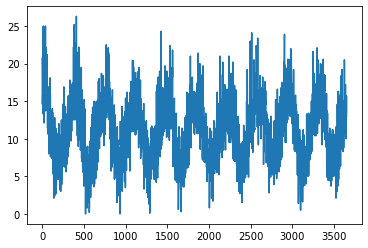

In [13]:
# df1 = csvFile['Births']
df1 = csvFile['Temp']
X = df1.values
plt.plot(X)

ADF Statistic: -4.913036
p-value: 0.000033
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
True


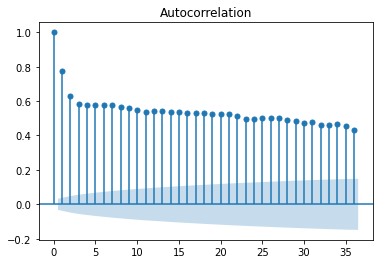

<Figure size 432x288 with 0 Axes>

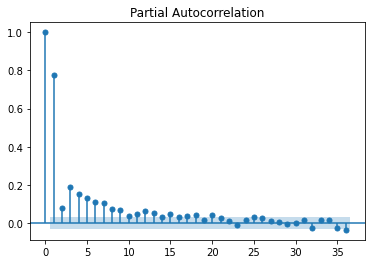

In [14]:
# result = adfuller(X, autolag='aic')
result = adfuller(df1, maxlag=52, autolag=None, regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

print(is_stationary(df1))
tsplot.plot_acf(X)
plt.figure()
tsplot.plot_pacf(X)    
plt.show()

In [15]:
res = sm.tsa.arma_order_select_ic(df1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)

(3, 1)
(3, 1)


In [16]:

trainRatio = .99
thresh = int(len(X)*trainRatio)
print(thresh)
X1 = df1[:thresh]
# print(X1)
d = d_param(X1)
# p, q = ARMA_params(df1)
res = sm.tsa.arma_order_select_ic(X1, ic=["aic", "bic"], trend="c")
print(res.aic_min_order)
print(res.bic_min_order)

d = min([2,d])
print(d)

3613
(3, 1)
(3, 1)
0


In [17]:
p = 3
q = 1
print(p,d,q)

3 0 1


0 / 37
1 / 37
2 / 37
3 / 37
4 / 37
5 / 37
6 / 37
7 / 37
8 / 37
9 / 37
10 / 37
11 / 37
12 / 37
13 / 37
14 / 37
15 / 37
16 / 37
17 / 37
18 / 37
19 / 37
20 / 37
21 / 37
22 / 37
23 / 37
24 / 37
25 / 37
26 / 37
27 / 37
28 / 37
29 / 37
30 / 37
31 / 37
32 / 37
33 / 37
34 / 37
35 / 37
36 / 37
MSE: 4.805994301019205
MAPE: 0.11650237597656375


Text(0, 0.5, 'Values')

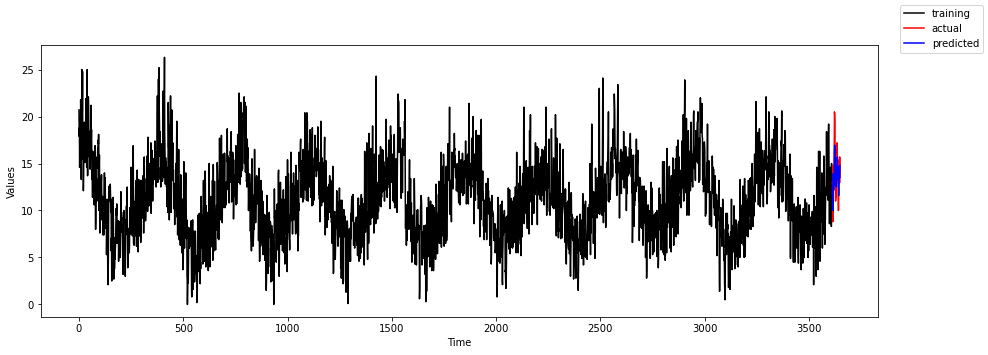

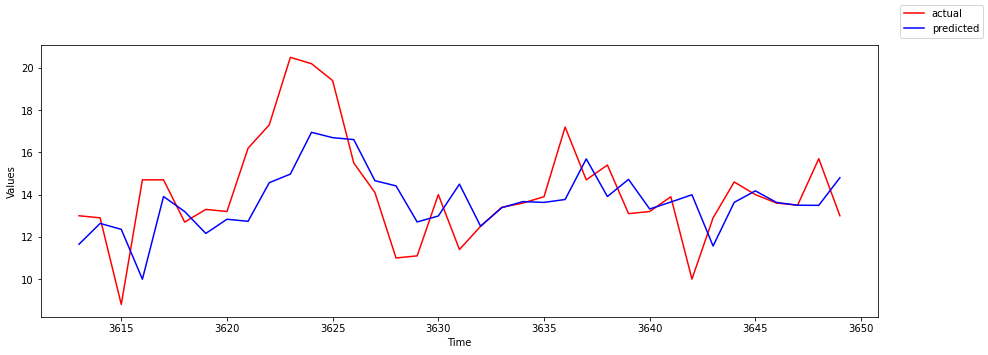

In [18]:

def evaluate_arima_model(X, arima_order, trainRatio):
    # prepare training dataset
    train_size = int(len(X)*trainRatio)
    train, test = X[:train_size], X[train_size:]

    history = [x for x in train]
    

    # make predictions
    predictions = []
    for i in range(0,len(test)):
        history1 = pd.DataFrame(np.asarray(history))

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]

        predictions.append(yhat)
        history.append(test[i])
        print(i,'/', len(test))

    mse_error = mean_squared_error(test, predictions)
    mape_error = mean_absolute_percentage_error(test, predictions)
        
    return mse_error, mape_error, train, test, predictions
    

    return error

arima_order = (p,d,q)

mse_error, mape_error, train, test, predictions = evaluate_arima_model(df1.values, arima_order, trainRatio)
print('MSE:', mse_error)
print('MAPE:', mape_error)


trainRange = np.arange(0,len(train),1)
testRange = np.arange(len(train), len(train) + len(test),1)
# print(trainRange)
# print(testRange)
ax = plt.figure(figsize=(15,5))
plt.plot(trainRange, train, 'k')
plt.plot(testRange,test,'r')
plt.plot(testRange,predictions,'b')
ax.legend(['training', 'actual', 'predicted'])
plt.xlabel('Time')
plt.ylabel('Values')

ax1 = plt.figure(figsize=(15,5))
plt.plot(testRange,test,'r')
plt.plot(testRange,predictions,'b')
ax1.legend(['actual', 'predicted'])
plt.xlabel('Time')
plt.ylabel('Values')
